## Ultimate Inc. Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score,precision_recall_curve, make_scorer,classification_report
import warnings
warnings.filterwarnings("ignore")

### Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
logins_df= pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#inspect keys
logins_df.keys()

Index(['login_time'], dtype='object')

In [5]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

In [6]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
#add count column for resample
logins_df['count'] = 1
#set login time as index for resampling
logins_df.index = logins_df['login_time']    

In [21]:
#drop redundant column
logins_df.drop('login_time',axis=1,inplace=True)
logins_df

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


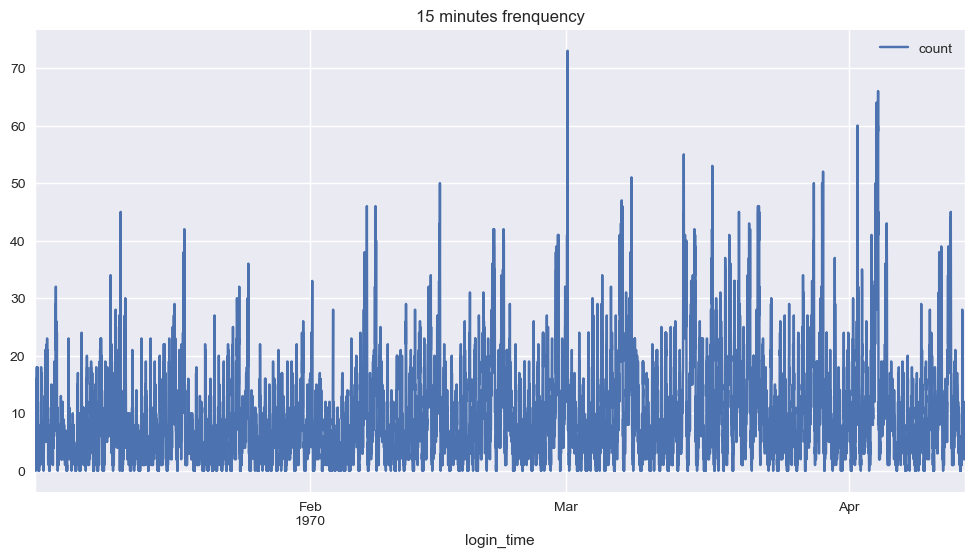

In [10]:
df_count = logins_df.resample('15min').sum()
df_count.plot(kind='line',figsize=(12,6))
plt.title('15 minutes frenquency')
plt.show()

We can clearly identify some kind of patterns in the peaks and troughs which seem to occur at a specified interval in every month. We can identify the pattern after observing the granular changes happening in a week

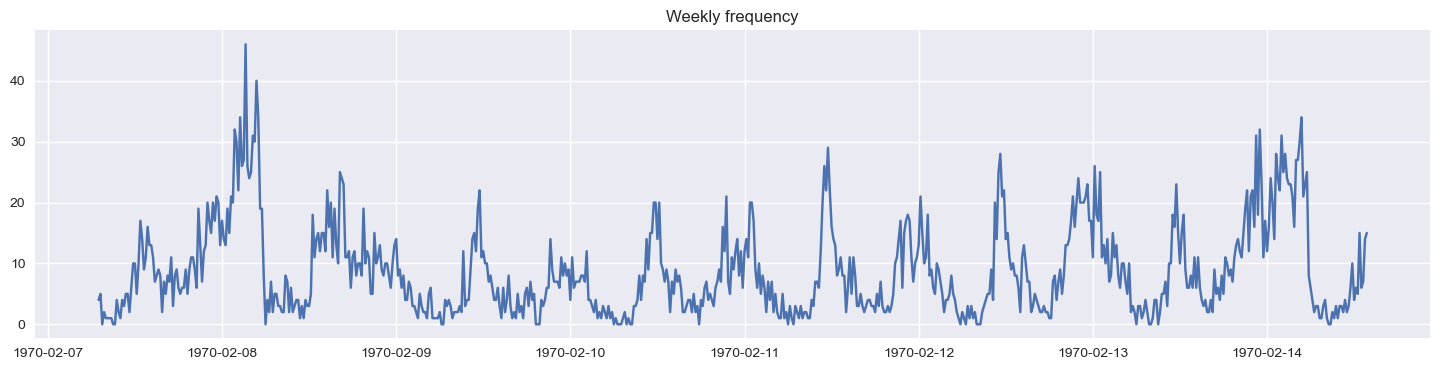

In [11]:
### plotting the data for any given week
plt.figure(figsize = (18,4))
plt.plot(df_count[3500:4200])
plt.title('Weekly frequency')
plt.show()

Observing the usage on a weekly basis tells us that peaks for the most part occur at an interval of every 12 hours.


In [12]:
df_count.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [13]:
#create new columns for items of interest
df_count = df_count.assign(month_day=df_count.index.day)
df_count = df_count.assign(weekday=df_count.index.weekday)
df_count.head()

,count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3


In [14]:
spike = np.quantile(df_count,0.99)
df_spike = df_count[df_count['count'] >= spike]
month_days = []
weekdays = []
for date in df_spike.index:
    month_days.append(date.day)
    weekdays.append(date.weekday())
    
df_spike_days = pd.DataFrame(month_days,columns=['day'],index=range(len(month_days)))
df_spike_weekdays = pd.DataFrame(weekdays,columns=['weekday'],index=range(len(weekdays)))

In [15]:
df_spike_days.day.value_counts()[0:10]

21    25
4     24
22    18
15    18
28    17
7     15
8     15
14    14
29    14
3     13
Name: day, dtype: int64

In [16]:
df_spike_weekdays.weekday.value_counts()

5    104
6    103
4     48
3     15
2      7
1      7
0      2
Name: weekday, dtype: int64

The spikes in user logins occur overwhelmingly on the weekends, which makes sense since many people will go out and socialize on the weekends.

Let's look now at the daily frequency data

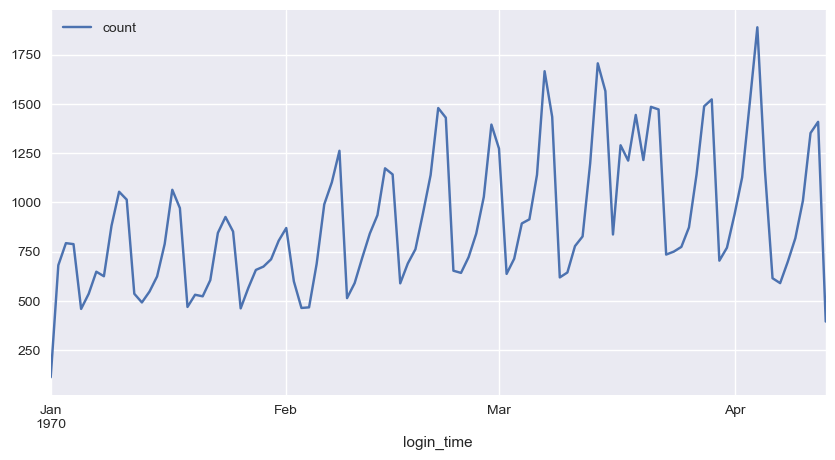

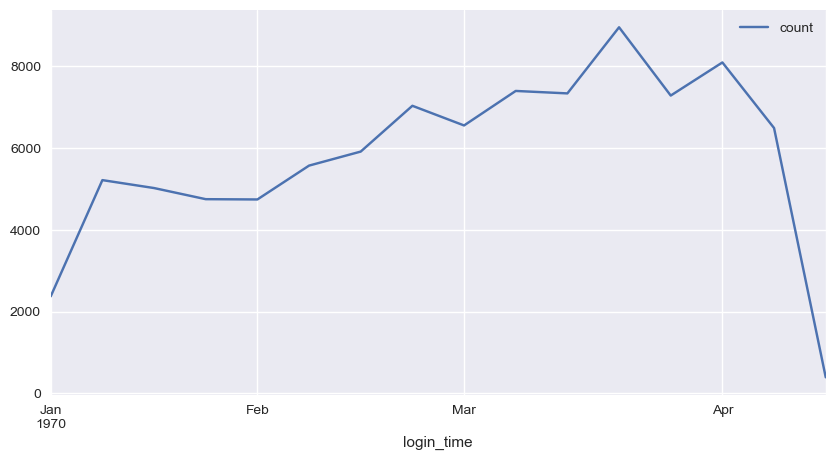

In [17]:
#resample to daily ans weekly frequency
df_day = logins_df.resample('1D').sum()
df_day.plot(kind='line', figsize=(10,5))
df_week= logins_df.resample('1W').sum()
df_week.plot(kind='line',figsize=(10,5))
plt.show()

Resampling to daily and weekly frequency shows there is an increasing trend of the average number of logins. At first, through the month of January, there seems to be little or no change in the average number of daily logins, then February starts the increasing trend.

#### Conclusion:
1. Peaks usually occur every 12 hours building slowly from morning and peaking in the noon, then come down, and another peak at night. 
2. Usage gradually increases during the course of a week peaking during a weekend.
3. There is a increasing trend starting from February

### Part 2 : Experiment and Metrics Design

There would be two ways to track the effectiveness of this campaign. One would be to
track the locations of the drivers using smartphone apps, and see the percentage of time during
working hours that they spend in either city. Another way to track effectiveness would be to
calculate how many drivers get reimbursement for the tolls during time they spent driving during
their working hours, however this may not be effective because this variable will automatically
jump from zero to something greater than zero, and will therefore be statistically significant and
not informative since it is basically guaranteed. Location should be tracked.

One thing to keep in mind is that working hours will differ depending on the city that the
driver is predominantly driving in, due to the different circadian rhythms of the cities. Their activity will probably remain unchanged during the week even with toll reimbursement in place. Therefore, since people are very active on the weekends usually, and assuming driver location can be tracked, I propose tracking the location of the driver during the weekend as the variable of interest for the experiment.

As for statistical testing, bootstrap testing can be used, but a parametric test using the
normal distribution will be better. Under the Central Limit Theorem, given a sufficiently large
sample size, the sampling distribution of the mean will approach the normal distribution. We can
use the normal distribution over the t-distribution, despite not knowing the population variance,
because we will have a high number of degrees of freedom in a large urban population. We will
employ a z-test to find the difference in means.

Steps of experiment:
1. Take a random sample of no less than 100 drivers
2. Calculate the percentage time that they spend in each city on the weekends
3. Implement the toll reimbursement policy for a set period and notify the drivers
4. After the period is complete, sample the same drivers and calculate the percentage time they spend driving in each city on the weekends, again.
5. Using a Z-test for proportions, at a chosen confidence level (99%), test the samples under the following setup
   H0: There is no difference in the mean proportions of times spent in each city
   Ha: There is a statistically significant difference in the mean proportions of times spent in each city
   
It is important that this experiment be conducted on normal weekends that are not
holidays and with no major events unless said events are ordinary, to prevent from artificially
inflating the results. Confidence Intervals should be generated for the mean proportions as well
in order to characterize the change in proportions over the test, if any. Also note that the higher
the sample size, the greater chance of their being a statistically significant difference detected,
even if that statistical significance does not translate to practical significance. The results of the
experiment should be interpreted in that light.

If the percentage of time spent in the non-dominant city goes up with statistical
significance, then the toll reimbursement has been effective in driving this effort. As for
prediction of the profit results, there must be a comparison in the end between the total cost of
the toll reimbursement vs the increased profit from having drivers available in both cities. The
toll reimbursement could be effective and still lose money for the company. It is critical that this
final step is taken.

### Part 3 : Predictive Modelling

#### Data description:

* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

#### Questions:
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [2]:
df=pd.read_json('ultimate_data_challenge.json')
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


#### change datatypes for faster runtime

In [19]:
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

In [20]:
np.finfo(np.float16).precision

3

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [6]:
# def set_dtypes(df):
#     return (df.assign(signup_date=pd.to_datetime(df.signup_date),
#                      last_trip_date=pd.to_datetime(df.last_trip_date)
#                      )
#               .astype({'city':'category', 'trips_in_first_30_days':'int16', 
#                'avg_rating_of_driver': 'float16','avg_surge': 'float16','surge_pct': 'float16',
#               'phone':'category', 'weekday_pct': 'float16',
#               'avg_dist': 'float16','avg_rating_by_driver': 'float16'})
#            )

def set_dtypes(df):
    return (df.assign(signup_date=pd.to_datetime(df.signup_date),
                     last_trip_date=pd.to_datetime(df.last_trip_date)
                     )
              .astype({'city':'category', 'trips_in_first_30_days':'int16', 
              'phone':'category', })
           )


In [7]:
df=set_dtypes(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int16         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), fl

In [60]:
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.699219,1.099609,2014-06-17,iPhone,15.398438,True,46.1875,3.669922,5.0,1
1,Astapor,0,2014-01-29,5.000000,1.000000,2014-05-05,Android,0.000000,False,50.0000,8.257812,5.0,0
2,Astapor,3,2014-01-06,4.300781,1.000000,2014-01-07,iPhone,0.000000,False,100.0000,0.770020,5.0,0


In [61]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [24]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

there are only three columns with missing values, we will:
1. one hot encode 'phone' column treating nan as a indicator
2. impute 'avg_rating_of_driver' and 'avg_rating_by_driver' using their mean value

In [8]:
df['avg_rating_of_driver']=df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver']=df['avg_rating_by_driver'].fbillna(df['avg_rating_by_driver'].mean())

In [10]:
current_date = df['last_trip_date'].max()
current_date

Timestamp('2014-07-01 00:00:00')

In [11]:
#find if user qualifies as active
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df['active']

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: active, Length: 50000, dtype: int64

In [63]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.699219,1.099609,2014-06-17,iPhone,15.398438,True,46.1875,3.669922,5.000000,1
1,Astapor,0,2014-01-29,5.000000,1.000000,2014-05-05,Android,0.000000,False,50.0000,8.257812,5.000000,0
2,Astapor,3,2014-01-06,4.300781,1.000000,2014-01-07,iPhone,0.000000,False,100.0000,0.770020,5.000000,0
3,King's Landing,9,2014-01-10,4.601562,1.139648,2014-06-29,iPhone,20.000000,True,80.0000,2.359375,4.898438,1
4,Winterfell,14,2014-01-27,4.398438,1.190430,2014-03-15,Android,11.796875,False,82.3750,3.130859,4.898438,0


In [28]:
df.active.value_counts()

0    31196
1    18804
Name: active, dtype: int64

In [29]:
df.active.value_counts(normalize=True)

0    0.62392
1    0.37608
Name: active, dtype: float64

37.6% of the observed users were retained

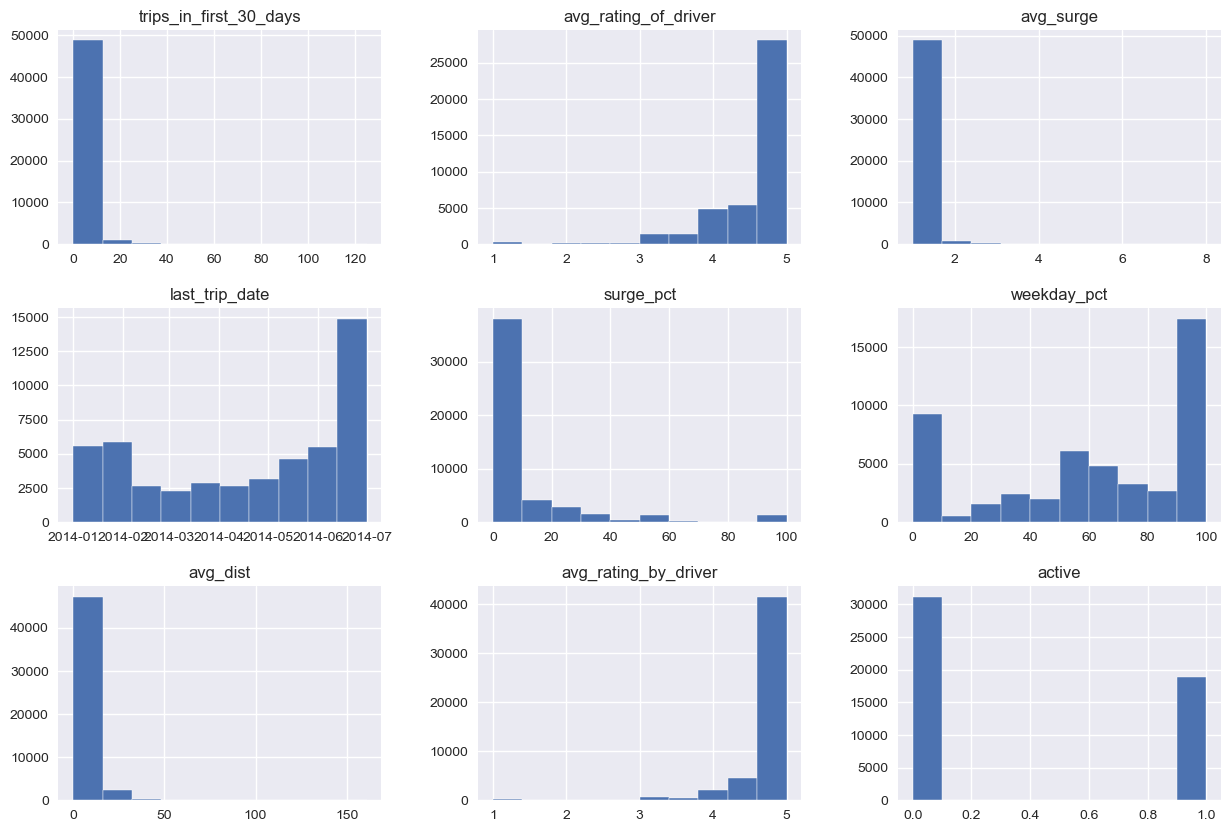

In [30]:
df.hist(figsize=(15,10))
plt.show()

In [117]:
num=df.select_dtypes([int, float])
num

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active
0,4,4.700000,1.10,15.4,46.2,3.67,5.0,1
1,0,5.000000,1.00,0.0,50.0,8.26,5.0,0
2,3,4.300000,1.00,0.0,100.0,0.77,5.0,0
3,9,4.600000,1.14,20.0,80.0,2.36,4.9,1
4,14,4.400000,1.19,11.8,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2,1
49996,1,4.601559,1.00,0.0,0.0,0.00,4.0,0
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0,0
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5,0


In [129]:
df.active.astype('bool')

0         True
1        False
2        False
3         True
4        False
         ...  
49995     True
49996    False
49997    False
49998    False
49999    False
Name: active, Length: 50000, dtype: bool

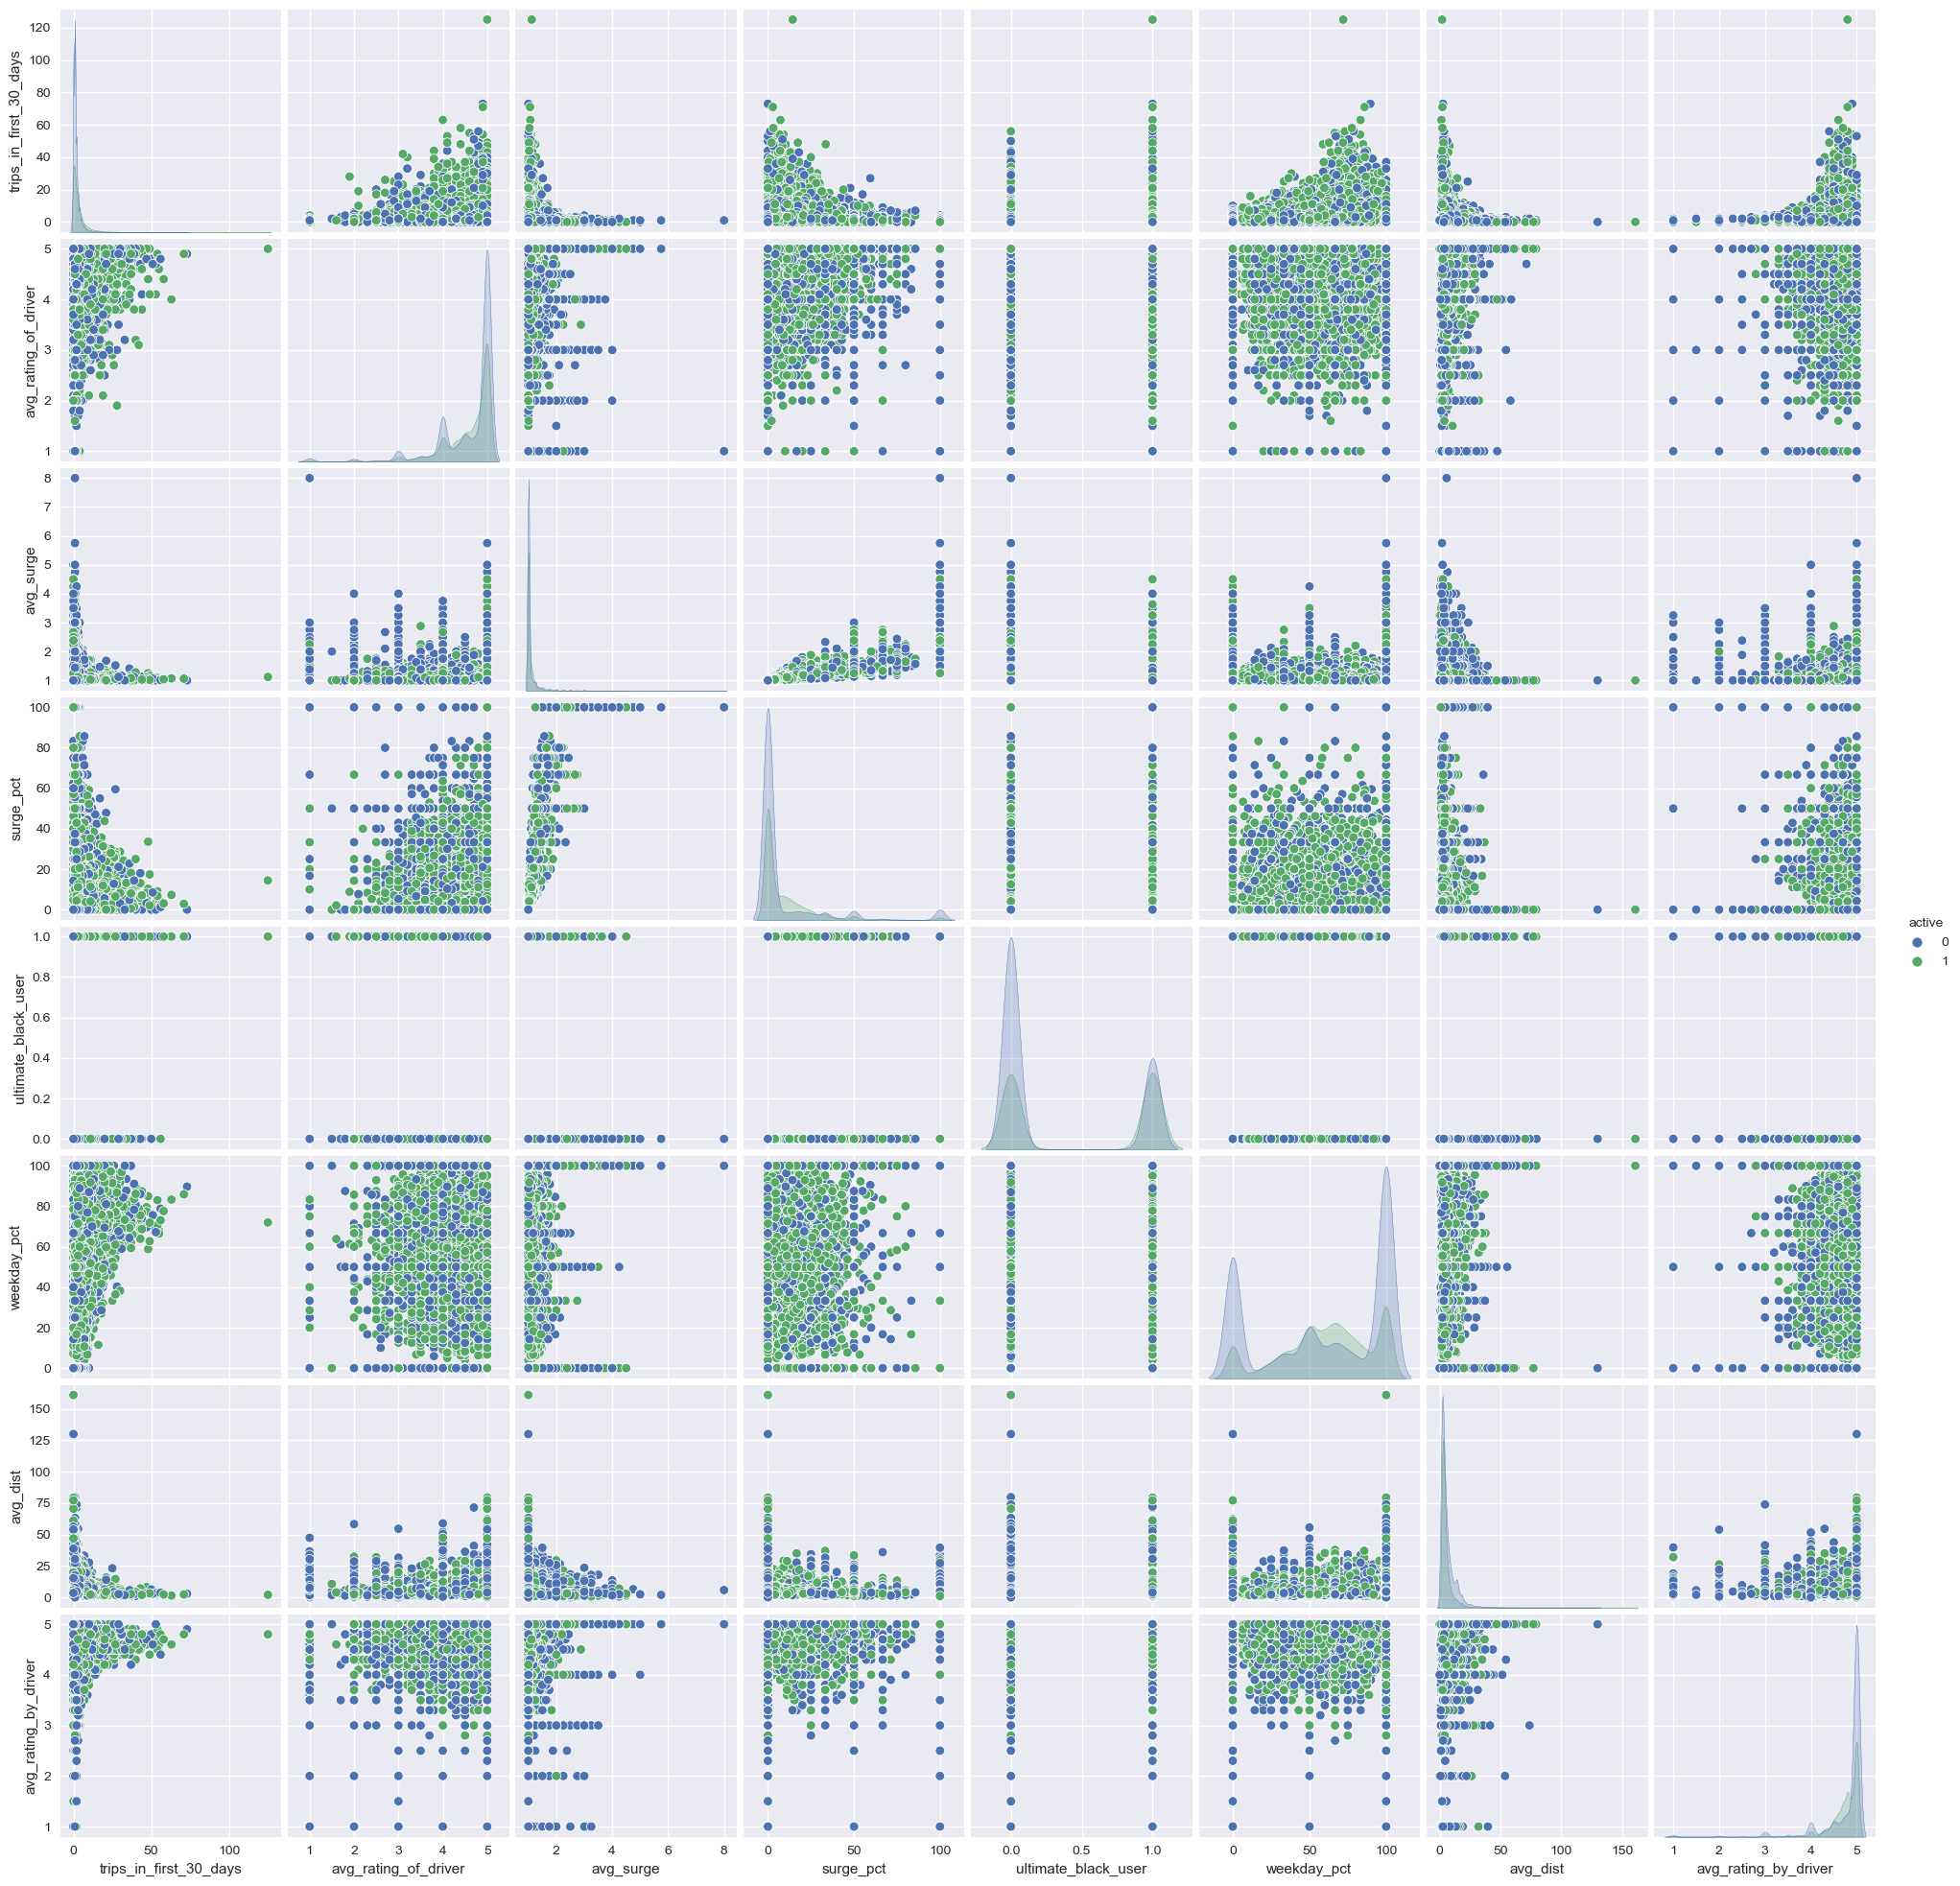

In [34]:
sns.pairplot(df, hue="active")
plt.show()

from the pairplot, seems like avg_dist and avg_rating_by_driver have differrent distribution among active and inacvtive users, plot these fearures to inspect

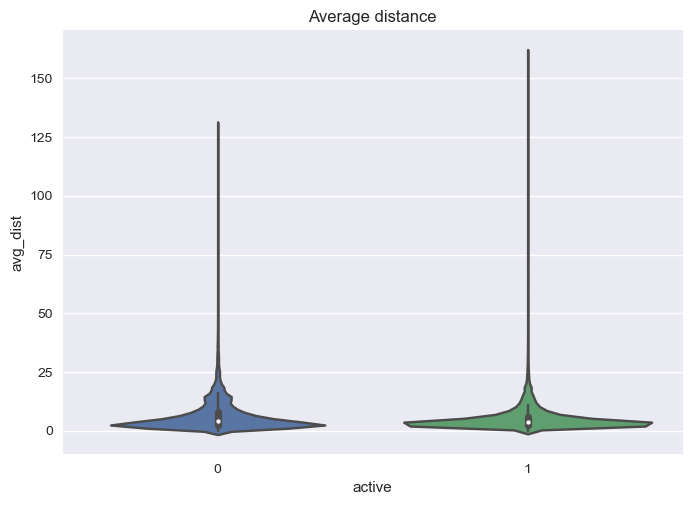

In [35]:
#visualize difference in average distance by activity of user
sns.violinplot(data=df,x='active',y='avg_dist')
plt.title('Average distance')
plt.show()

In [36]:
pd.pivot_table(df,index='active',aggfunc={'avg_dist':['mean','std']})

avg_dist          
            mean       std
active                    
0       6.207939  6.238675
1       5.114788  4.615175

There is a difference in the average distance per trip taken in the first 30 days between active users and inactive users

(3.5, 5.2)

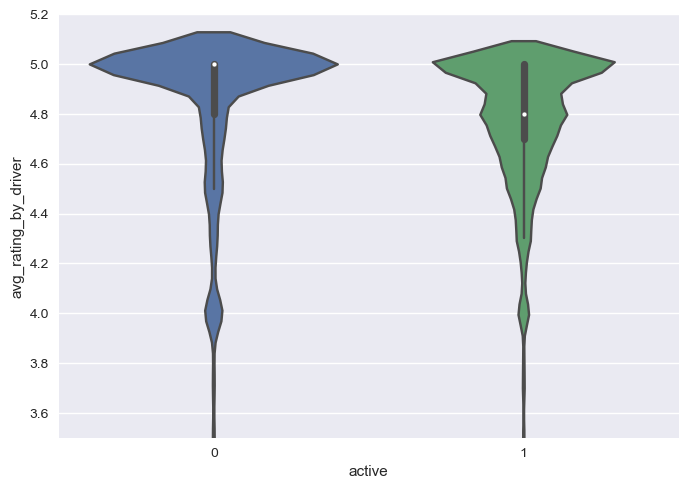

In [37]:
sns.violinplot(data=df,x='active',y='avg_rating_by_driver')
plt.ylim([3.5,5.2])

In [38]:
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['mean','std']})

avg_rating_by_driver          
                       mean       std
active                               
0                  4.787464  0.504648
1                  4.762772  0.328489

there is liitle to none difference in mean, but big difference in std, might be useful

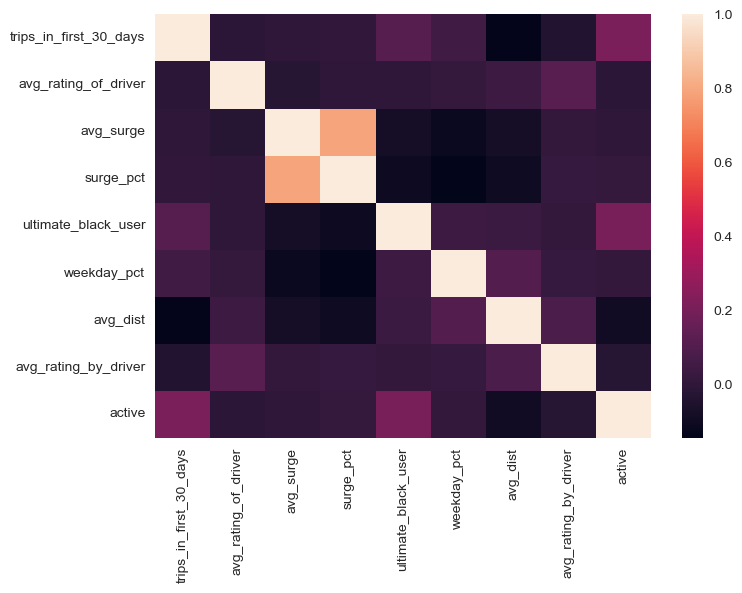

In [46]:
sns.heatmap(df.corr())
plt.show()

from the heatmap:
1. avg_surge and surge_pct are highly correlated, which makes sense
2. trips_in_first_30_days, ultimate_black_user, and active are somewhat correlated


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int16         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active                  50000 non-null  int64 

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.601559,0.564977,1.0,4.50,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778158,0.445753,1.0,4.70,5.00,5.00,5.00
active,50000.0,0.376080,0.484405,0.0,0.00,0.00,1.00,1.00


#### buling a Random Forest model
one of the advantages of random forest models is its interpretability, we can get the model's feature importance to see which features played a bigger role in the model

In [14]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000, 12), (15000, 12), (35000,), (15000,))

In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,35000.0,2.281200,3.773701,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,35000.0,4.602248,0.564894,1.0,4.50,4.80,5.00,5.00
avg_surge,35000.0,1.075398,0.227047,1.0,1.00,1.00,1.05,8.00
surge_pct,35000.0,8.895386,20.103766,0.0,0.00,0.00,8.50,100.00
weekday_pct,35000.0,60.882994,37.084765,0.0,33.30,66.70,100.00,100.00
avg_dist,35000.0,5.796847,5.630138,0.0,2.43,3.89,6.95,129.89
avg_rating_by_driver,35000.0,4.778522,0.443712,1.0,4.70,5.00,5.00,5.00


In [17]:
from sklearn.ensemble import RandomForestClassifier
#### pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

### pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

## setting up pipeline
preprocess = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)])

## random forest estimator
pipeline = Pipeline(steps = [("pre", preprocess), ("rf", RandomForestClassifier(random_state = 42))])

## some parameters for grid search
params = {"rf__n_estimators": [50,75,100],
          "rf__max_depth": [2, 3, 5]}

## fitting pipeline to grid search
cv = GridSearchCV(pipeline, param_grid = params, cv = 3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [2, 3, 5],
                         'rf__n_estimators': [50, 75, 100]})

In [19]:
print("Top parameters are: {}".format(cv.best_params_))
print("Accuracy from the best model is {}".format(cv.best_score_*100))

Top parameters are: {'rf__max_depth': 5, 'rf__n_estimators': 100}
Accuracy from the best model is 76.88572004405958


In [20]:
y_pred=cv.predict(X_test)

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      9359
           1       0.76      0.57      0.65      5641

    accuracy                           0.77     15000
   macro avg       0.77      0.73      0.74     15000
weighted avg       0.77      0.77      0.76     15000



In [25]:
pipeline.fit(X_train, y_train)
feat_weights = pipeline.named_steps['rf'].feature_importances_

In [26]:
feat_weights

array([0.29581756, 0.11309177, 0.08197206, 0.07172998, 0.07238389,
       0.08267141, 0.13262549, 0.01842814, 0.04824113, 0.01178242,
       0.01874353, 0.02009746, 0.00115538, 0.01539851, 0.01586128])

In [30]:
num_columns = df[numeric_features].columns.values
cat_columns = pd.get_dummies(df[categorical_features]).columns.values
tot_col = list(num_columns) + list(cat_columns)

weight_dict = dict(zip(tot_col, feat_weights))
sorted_dict  = sorted(weight_dict.items(), key = lambda x: x[1], reverse = True)

In [31]:
sorted_dict

[('avg_dist', 0.2958175617499373),
 ('weekday_pct', 0.13262549056753697),
 ('avg_rating_by_driver', 0.11309176832747025),
 ('trips_in_first_30_days', 0.08267140751077352),
 ('avg_rating_of_driver', 0.08197206273166954),
 ('surge_pct', 0.07238389405504143),
 ('avg_surge', 0.07172997634122831),
 ('city_Astapor', 0.04824112910926169),
 ('phone_Android', 0.020097463786062163),
 ('city_Winterfell', 0.01874352597703317),
 ('ultimate_black_user', 0.018428142437483728),
 ("city_King's Landing", 0.011782416820860779),
 ('phone_iPhone', 0.0011553769640415767)]

We can clearly see avg_dist has the highest weight among all features along with weekday_pct being the next most important feature. 

#### build a XGboost model
XGboost is the winning model for many kaggle comptitions, generally speaking, it has higher accuracy.

In [47]:
from xgboost import XGBClassifier

pipeline = Pipeline(steps = [("pre", preprocess), ("xgb", XGBClassifier(random_state = 42))])

params = {"xgb__n_estimators": [50,75,100],
          "xgb__learning_rate": [0.01, 0.1, 1],
          "xgb__max_depth": [4, 8, 12]
         }

cv = GridSearchCV(pipeline, param_grid = params, cv = 3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user']...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1, 1],
                         'xgb__max_depth': [4, 8, 12],
                         'xgb__n_estimators': [50, 75, 100]})

In [49]:
print("Top parameters are: {}".format(cv.best_params_))
print("Accuracy from the best model is {}".format(cv.best_score_*100))

Top parameters are: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 100}
Accuracy from the best model is 78.6171557205588


In [54]:
results=pd.DataFrame(cv.cv_results_)[['param_xgb__learning_rate','param_xgb__max_depth',
                                      'param_xgb__n_estimators','mean_test_score','rank_test_score']]
results.sort_values('rank_test_score')

,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,mean_test_score,rank_test_score
11,0.1,4,100,0.786172,1
13,0.1,8,75,0.785400,2
14,0.1,8,100,0.785172,3
10,0.1,4,75,0.784372,4
12,0.1,8,50,0.784257,5
9,0.1,4,50,0.782457,6
16,0.1,12,75,0.778372,7
17,0.1,12,100,0.777943,8
5,0.01,8,100,0.777943,9
15,0.1,12,50,0.777572,10


In [48]:
y_pred=cv.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      9359
           1       0.74      0.67      0.71      5641

    accuracy                           0.79     15000
   macro avg       0.78      0.77      0.77     15000
weighted avg       0.79      0.79      0.79     15000



In [56]:
pipeline.fit(X_train, y_train)
feat_weights = pipeline.named_steps['xgb'].feature_importances_
feat_weights

array([0.01484559, 0.13350542, 0.01768662, 0.02178536, 0.05846217,
       0.02767762, 0.04145079, 0.06269918, 0.3063687 , 0.0100224 ,
       0.10276611, 0.12399335, 0.00944386, 0.06929288, 0.        ],
      dtype=float32)

In [57]:
weight_dict = dict(zip(tot_col, feat_weights))
sorted_dict  = sorted(weight_dict.items(), key = lambda x: x[1], reverse = True)
sorted_dict

[('city_Astapor', 0.3063687),
 ('avg_rating_by_driver', 0.13350542),
 ('phone_Android', 0.12399335),
 ('city_Winterfell', 0.10276611),
 ('ultimate_black_user', 0.062699184),
 ('surge_pct', 0.058462165),
 ('weekday_pct', 0.041450795),
 ('trips_in_first_30_days', 0.027677624),
 ('avg_surge', 0.021785356),
 ('avg_rating_of_driver', 0.017686617),
 ('avg_dist', 0.014845589),
 ("city_King's Landing", 0.0100224),
 ('phone_iPhone', 0.0094438605)]

We got different feature importances. Although these two are similar models not same ( Random forest uses bagging ensemble model while XGBoost uses boosting ensemble model), so it may differ sometimes in results. Now let me tell you why this happens.

When the correlation between the variables are high, XGBoost will pick one feature and may use it while breaking down the tree further(if required) and it will ignore some/all the other remaining correlated features(because we will not be able to learn different aspects of the model by using these correlated feature because it is already highly correlated with the chosen feature).

But in random forest , the tree is not built from specific features, rather there is random selection of features (by using row sampling and column sampling), and then the model in whole learn different correlations of different features. 

When specifying importance_type='total_gain' in XGBoost seems to produce more comparable rankings.

In [58]:
pipeline = Pipeline(steps = [("pre", preprocess), 
                             ("xgb", XGBClassifier(importance_type="total_gain", random_state = 42))])

params = {"xgb__n_estimators": [100,200,500],
          "xgb__learning_rate": [0.1],
          "xgb__max_depth": [4, 8]
         }

cv = GridSearchCV(pipeline, param_grid = params, cv = 3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user']...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.1], 'xgb__max_depth': [4, 8],
                         'xgb__n_estimators': [100, 200, 500]})

In [59]:
results=pd.DataFrame(cv.cv_results_)[['param_xgb__learning_rate','param_xgb__max_depth',
                                      'param_xgb__n_estimators','mean_test_score','rank_test_score']]
results.sort_values('rank_test_score')

,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,mean_test_score,rank_test_score
2,0.1,4,500,0.787686,1
1,0.1,4,200,0.787229,2
0,0.1,4,100,0.786172,3
3,0.1,8,100,0.785172,4
4,0.1,8,200,0.784600,5
5,0.1,8,500,0.779714,6


In [60]:
y_pred=cv.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9359
           1       0.75      0.67      0.71      5641

    accuracy                           0.79     15000
   macro avg       0.78      0.77      0.77     15000
weighted avg       0.79      0.79      0.79     15000



In [61]:
pipeline.fit(X_train, y_train)
feat_weights = pipeline.named_steps['xgb'].feature_importances_
feat_weights

array([0.09779361, 0.24277622, 0.0432852 , 0.03641943, 0.09773348,
       0.0736835 , 0.1325075 , 0.02760063, 0.12523243, 0.00409679,
       0.03985285, 0.03054035, 0.0005444 , 0.04793363, 0.        ],
      dtype=float32)

In [62]:
weight_dict = dict(zip(tot_col, feat_weights))
sorted_dict  = sorted(weight_dict.items(), key = lambda x: x[1], reverse = True)
sorted_dict

[('avg_rating_by_driver', 0.24277622),
 ('weekday_pct', 0.1325075),
 ('city_Astapor', 0.12523243),
 ('avg_dist', 0.09779361),
 ('surge_pct', 0.097733475),
 ('trips_in_first_30_days', 0.0736835),
 ('avg_rating_of_driver', 0.0432852),
 ('city_Winterfell', 0.039852854),
 ('avg_surge', 0.036419425),
 ('phone_Android', 0.03054035),
 ('ultimate_black_user', 0.027600627),
 ("city_King's Landing", 0.0040967935),
 ('phone_iPhone', 0.00054440234)]

first five featrure in random forest are:
avg_dist, weekday_pct, avg_rating_by_driver, trips_in_first_30_days, avg_rating_of_driver

first five featrure in XGBoost are:
avg_rating_by_driver, weekday_pct, city_Astapor, avg_dist, surge_pct

overlap is avg_dist,weekday_pct, avg_rating_by_driver

### Conclusion:

First, 37.6% of the observed users were retained

Secondly, we have built a predictive model with 79% accuracy, that will be useful for future prediction.

Thirdly, we extracted three most important features:
1. average distance: users who are active travels shorter distance, which make sense, since the longer the trip, more expensive the fare, people travel long distance often probabaly will own a car.
2. weekday percentage: The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app on the weekend will be beneficial for the company revenue.
3. average rating by driver: For this feature, there is a decreased likelihood of being an active user as your rating goes up.

Based on these insights gained from the model, there are several recomendations for the company:
1. Offer incentives to riders who mostly travels shorter distance.
2. Offer incentives to riders to use the app on the weekends.
3. Encourage drivers not to artificially inflate the ratings they give to users, especially if the driver can tell that they've never done this before.

Following these guidelines will increase the chances of more active users in the long term, and therefore more revenue for the company.